<a href="https://colab.research.google.com/github/jhlopesalves/data-science-notebooks/blob/main/Python/projects/california_house_pricing/california.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California Housing Prices: A Regression Analysis

![california_housing](https://github.com/jhlopesalves/data-science-notebooks/blob/main/Python/projects/california_house_pricing/data/california_housing.jpg?raw=true)

This notebook documents the process of building a machine learning model to predict median house values in California districts. The analysis uses the California Housing dataset, which is based on data from the 1990 census. The primary objective is to explore the data, engineer meaningful features, and ultimately create a regression model that can accurately estimate house prices based on demographic and geographic attributes.

Each row in the dataset corresponds to a **block group**, which is the smallest geographical unit for which the U.S. Census Bureau publishes sample data.

## Dataset Description

| Variable | Definition |
| :--- | :--- |
| `MedInc` | Median income for households in the block group (in tens of thousands of US Dollars). |
| `HouseAge` | Median age of a house within the block group. |
| `AveRooms` | The average number of rooms per household. |
| `AveBedrms` | The average number of bedrooms per household. |
| `Population`| The total population within the block group. |
| `AveOccup` | The average household occupancy (number of members). |
| `Latitude` | The latitude of the block group's centroid. |
| `Longitude`| The longitude of the block group's centroid. |
| `target` | **Target Variable:** The median house value (in hundreds of thousands of US Dollars). |

## Notebook Workflow
This analysis is structured into several key stages:
1.  **Exploratory Data Analysis (EDA):** Initial investigation of the data to understand its structure, identify correlations, and visualise the spatial distribution of house prices.
2.  **Feature Engineering:** Creation of new, informative features. This notebook focuses heavily on creating a robust geographical feature (`Region_cv`) using K-means clustering, ensuring its creation is free from data leakage by nesting the process within a cross-validation framework.
3.  **Data Preprocessing:** Preparing the data for machine learning models, which includes handling missing values and scaling numerical features.
4.  **Model Building and Evaluation:** Training various regression models and evaluating their performance using appropriate metrics and cross-validation strategies to select the best-performing model.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)

In [ ]:
# Load data
housing = fetch_california_housing(as_frame=True)
housing_df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
housing_df["target"] = housing.target
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Exploratory plot: spatial pattern of prices

This plot provides an initial exploration of how median house values are distributed geographically. Each point represents a location, and its colour indicates the house price, allowing for a quick visual assessment of spatial patterns.

### Representing Geographic Data
The visualisation plots longitude against latitude directly onto a two-dimensional grid. This technique, known as an equirectangular projection, is a straightforward way to map spherical coordinates (P(ϕ,λ)) to a Cartesian plane ((x,y)).

While simple, this method does not preserve true distances or areas. For a limited region like California, the visual distortion is minimal, making it suitable for this kind of exploratory analysis. However, for precise cartographic work, a library like geopandas would be necessary to apply a more appropriate projection that accurately reflects the geography.

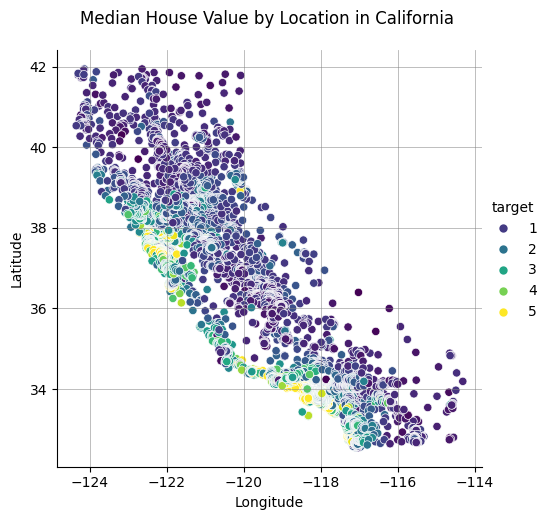

In [ ]:
g = sns.relplot(
    x="Longitude",
    y="Latitude",
    hue="target",
    data=housing_df,
    kind="scatter",
    palette="viridis",
)
g.fig.suptitle(
    "Median House Value by Location in California", y=1.03
)  # Add title to the FacetGrid
g.set_axis_labels("Longitude", "Latitude")
for ax in g.axes.flat:
    ax.grid(True, alpha=0.6, linewidth=0.6, color="grey")
g.fig.subplots_adjust(top=0.95)  # Adjust layout to prevent title overlap
plt.show()

### Preparing Geographic Features for Clustering

Latitude and longitude need a small correction before clustering:

1. **Cosine correction** – Longitude distances shrink as you move away from the equator.  
   We scale longitude by `cos(mean latitude)` so that distances are more realistic in California’s region.

2. **Standardisation** – K-Means is based on Euclidean distances, so features must be on comparable scales.  
   We use `StandardScaler` to normalise latitude and adjusted longitude to zero mean and unit variance.

The result is `coords_scaled`, a 2D array suitable for applying K-Means clustering.


In [ ]:
from sklearn.preprocessing import StandardScaler

# Cosine correction for longitude at the dataset's mean latitude
mean_latitude = housing_df["Latitude"].mean()
longitude_scale = np.cos(np.deg2rad(mean_latitude))

# Copy lat/lon and apply the correction, then standardise for Euclidean K-means
coords = housing_df[["Latitude", "Longitude"]].copy()
coords["Longitude"] = coords["Longitude"] * longitude_scale

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords.values)

### Choosing the Number of Clusters with the Silhouette Score

K-Means requires us to predefine the number of clusters `k`.  
To guide this choice, we evaluate models with `k` ranging from 3 to 9.

- **Silhouette score** measures how well each point fits within its cluster compared to other clusters.  
  - Values close to **1** mean points are well matched to their cluster.  
  - Values near **0** indicate overlapping clusters.  
  - Negative values suggest poor assignment.

We record the silhouette score for each candidate `k` to identify the most coherent clustering structure.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = {}
for k in range(3, 10):
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    labels = km.fit_predict(coords_scaled)
    scores[k] = silhouette_score(coords_scaled, labels)

scores

{3: 0.6466777410810406,
 4: 0.6073512184677257,
 5: 0.5818378691628111,
 6: 0.5695294679006102,
 7: 0.5720925035131836,
 8: 0.5277806614950171,
 9: 0.49734927483895147}

### Out-of-Fold Clustering Features (Leakage-Safe)

To avoid information leakage, we generate cluster-based features using **out-of-fold (OOF) K-Means**:

- We fix `k = 4` clusters (chosen from silhouette analysis).
- Data is split into 5 folds with `KFold`.
- For each fold:
  - K-Means is fitted only on the **training portion**.
  - Cluster labels and distances are predicted for the **validation portion**.
- This ensures that each row receives cluster features from a model that never saw it during training.

The output:
- `Region_cv`: categorical cluster label per row.  
- `RegionDist_cv_*`: numeric distance to each centroid, providing richer spatial information.

This method prevents leakage and produces clustering features that can safely be used in cross-validation workflows.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

k = 4  # set from Cell 2
n = coords_scaled.shape[0]

# Preallocate out-of-fold containers
oof_labels = np.full(n, -1, dtype=int)
oof_dists = np.zeros((n, k), dtype=float)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in kf.split(coords_scaled):
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    km.fit(coords_scaled[train_idx])  # fit only on the training fold
    oof_labels[valid_idx] = km.predict(
        coords_scaled[valid_idx]
    )  # fill VALIDATION rows ONLY
    oof_dists[valid_idx] = km.transform(
        coords_scaled[valid_idx]
    )  # distances for VALIDATION rows

# Safety checks: every row must have been validation exactly once
assert (oof_labels != -1).all(), "Some rows were never assigned."
assert np.isfinite(oof_dists).all(), "Distances contain non-finite values."

# Attach features
housing_df["Region_cv"] = pd.Categorical(oof_labels)
for cluster_id in range(k):
    housing_df[f"RegionDist_cv_{cluster_id}"] = oof_dists[:, cluster_id]

### Visualising Geographic Clusters

To better understand the K-Means clustering, we plot each housing block by its **latitude and longitude**:

- Points are coloured by their assigned `Region_cv` cluster.  
- The `viridis` palette ensures clusters are visually distinct yet perceptually uniform.  
- Adding grid lines helps align cluster boundaries with geographic positions.

This plot reveals whether clusters correspond to meaningful **geographic regions** in California, such as coastal vs inland areas or northern vs southern regions.


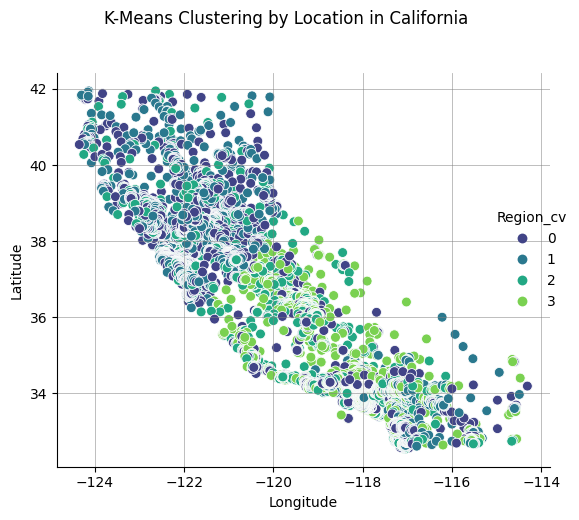

In [ ]:
g_cluster = sns.relplot(
    x="Longitude",
    y="Latitude",
    hue="Region_cv",
    data=housing_df,
    kind="scatter",
    palette="viridis",
    s=50,
)
g_cluster.fig.suptitle("K-Means Clustering by Location in California", y=1.03)
g_cluster.set_axis_labels("Longitude", "Latitude")
g_cluster.fig.subplots_adjust(top=0.95)

for ax in g_cluster.axes.flat:
    ax.grid(True, alpha=0.6, linewidth=0.6, color="grey")

plt.tight_layout()
plt.show()

## Define a clean modelling table

We select the columns used for modelling and keep a predictable order:

- Socio-economic and dwelling features: `MedInc`, `HouseAge`, `AveRooms`, `AveBedrms`, `AveOccup`, `Population`.
- Spatial signals: `Region_cv` (categorical macro-region), `Latitude`, `Longitude` (continuous fine detail).
- Target: `target`.

Rationale:
- Keeping both fine-grained coordinates **and** a macro-region flag lets models learn broad baselines and local variation.
- We will treat `Region_cv` as categorical in preprocessing. Coordinates remain floats.


In [ ]:
housing_df = housing_df[
    [
        "MedInc",
        "HouseAge",
        "AveRooms",
        "AveBedrms",
        "AveOccup",
        "Population",
        "Region_cv",
        "Latitude",
        "Longitude",
        "target",
    ]
]
housing_df

,MedInc,HouseAge,AveRooms,AveBedrms,AveOccup,Population,Region_cv,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,2.555556,322.0,1,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2.109842,2401.0,1,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,2.802260,496.0,0,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,2.547945,558.0,1,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,2.181467,565.0,1,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,2.560606,845.0,1,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,3.122807,356.0,2,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,2.325635,1007.0,0,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,2.123209,741.0,1,39.43,-121.32,0.847


## One-hot encode the categorical region

We create dummy variables for `Region_cv` and keep all numeric columns as they are.

Why:
- **Linear models** require one-hot encoding for categorical variables. Without it, a linear model would treat cluster IDs as ordered numbers, which is meaningless.
- For tree models, one-hot is also robust in scikit-learn because trees split on thresholds and would otherwise impose an arbitrary order on labels.

Note:
- `drop_first=True` removes one dummy to avoid perfect collinearity in linear regression. Tree models do not require this, but keeping a single design matrix for all models simplifies the pipeline.


In [ ]:
housing_with_dummies = pd.get_dummies(
    housing_df, columns=["Region_cv"], drop_first=True
)
housing_with_dummies.head()

,MedInc,HouseAge,AveRooms,AveBedrms,AveOccup,Population,Latitude,Longitude,target,Region_cv_1,Region_cv_2,Region_cv_3
0,8.3252,41.0,6.984127,1.023810,2.555556,322.0,37.88,-122.23,4.526,True,False,False
1,8.3014,21.0,6.238137,0.971880,2.109842,2401.0,37.86,-122.22,3.585,True,False,False
2,7.2574,52.0,8.288136,1.073446,2.802260,496.0,37.85,-122.24,3.521,False,False,False
3,5.6431,52.0,5.817352,1.073059,2.547945,558.0,37.85,-122.25,3.413,True,False,False
4,3.8462,52.0,6.281853,1.081081,2.181467,565.0,37.85,-122.25,3.422,True,False,False


### Train-Test Split and Repeated Cross-Validation Setup

We now move to model evaluation. The dataset is split into:

- **Training set (80%)**: used for fitting models and performing cross-validation.  
- **Test set (20%)**: kept untouched until the very end, to provide a final, unbiased estimate of performance.

To estimate model reliability, we use **Repeated K-Fold cross-validation**:
- 5 folds, repeated 5 times → 25 resamples in total.  
- Each observation appears in validation exactly once per repeat.  
- Repetition reduces variance in the performance estimate, making results more robust than a single split.

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate, train_test_split

X = housing_with_dummies.drop("target", axis=1)
y = housing_with_dummies["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Repeated K-Fold cross-validation repeats standard K-Fold multiple times to reduce variability in performance estimates
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

### Cross-validation outputs and metrics (reusable note)

We evaluate each model with **Repeated K-Fold CV** (5×5 = 25 folds) and collect a tidy dataframe of scores:

- **RMSE (root mean squared error)** — sensitive to large errors; same units as the target.  
- **MAE (mean absolute error)** — median-friendly, robust to outliers relative to RMSE.  
- **R² (coefficient of determination)** — proportion of variance explained (can be negative out-of-sample).  
- **MAPE (mean absolute percentage error)** — scale-free percentage error; unstable if the target can be near zero.

Implementation details to remember:
- Scikit-learn’s `"neg_*"` scorers return **negative values** for loss metrics; we multiply by −1 to read them on their natural positive scale.
- We summarise the 25 fold scores with **mean ± standard deviation**. The mean is our central estimate; the standard deviation reflects variability across splits.
- Use the **same `cv` splitter** for every model so that fold-wise results are paired and differences are comparable.


### Linear Regression

**Linear Regression** serves as a transparent baseline:
- It estimates a linear relationship between features and the target via least squares.
- Coefficients are directly interpretable as marginal effects (holding other features fixed).

Practical notes:
- With one-hot encoded features, multicollinearity can inflate variance; the point predictions remain unbiased, but uncertainty grows. A regularised baseline (Ridge/Lasso) is a natural next step if variance is high.
- Violations of homoscedasticity or linearity will typically show up as **systematic patterns in residual plots** and relatively weaker RMSE/R² than tree-based models.
- We do **not** tune hyperparameters here; the goal is to establish a clean, honest reference for subsequent models (RF/GB/ XGB).

Read the CV summary as: “typical performance over many plausible train/validation splits,” and compare it later with the final hold-out test to check stability.


In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

# Cross-validate the model using specified scoring metrics; negative signs for losses are flipped later for interpretation
cv_lr = cross_validate(
    estimator=reg,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring={
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "r2": "r2",
        "mape": "neg_mean_absolute_percentage_error",
    },
    n_jobs=-1,
    return_train_score=False,
)

# Create a DataFrame from cross-validation results, flipping signs for loss metrics to positive values
scores_lr = pd.DataFrame(
    data={
        "rmse": -cv_lr["test_rmse"],
        "mae": -cv_lr["test_mae"],
        "r2": cv_lr["test_r2"],
        "mape": -cv_lr["test_mape"],
    }
)

# Compute mean and standard deviation for each metric across folds to summarize performance
summary_lr = scores_lr.agg(func=["mean", "std"]).round(4)
print("Repeated CV (train only) - mean and sd over 25 folds")
display(summary_lr)

Repeated CV (train only) - mean and sd over 25 folds


,rmse,mae,r2,mape
mean,0.7397,0.5296,0.5837,0.3154
std,0.0955,0.0091,0.1386,0.0081


### Confidence Intervals for Cross-Validation Metrics (general note)

Point estimates like mean RMSE or mean R² can be misleading without a sense of **uncertainty**.  
To capture that uncertainty, we compute **95% confidence intervals (CIs)** for each metric:

- We treat the per-fold scores as samples from an underlying distribution.  
- The standard error of the mean is estimated as `std / sqrt(n)`, where `n` is the number of folds.  
- Using the *t-distribution* (with `df = n−1`) accounts for finite sample sizes.  
- The interval is:  
  $$
  \bar{x} \pm t_{\alpha/2, df} \cdot \frac{s}{\sqrt{n}}
  $$
  where $\bar{x}$ is the mean and $s$ is the standard deviation of the folds.

Interpretation: If we repeated the resampling process many times, ~95% of such intervals would contain the true mean score.

### Linear Regression: 95% CI of CV Results

For the Linear Regression model:

- Each metric (RMSE, MAE, R², MAPE) is summarised with a **mean value** and a **confidence interval**.  
- The CI shows the plausible range for the *average* performance across unseen splits.  
- If another model’s CI does not overlap much with Linear Regression’s, the difference is more likely to be **statistically meaningful** rather than noise.  
- Later, when we compute CIs for tree-based models, we can directly compare intervals to assess whether one model is consistently better.

This step transforms the CV results from “a single point estimate” into a more cautious **range estimate**, which is closer to how results should be reported in research and professional practice.


In [ ]:
from scipy.stats import t

# Calculate the number of cross-validation folds (n) from the scores DataFrame
n = len(scores_lr)

# Compute the critical value from the t-distribution (tcrit) for a 95% confidence interval (two-tailed, alpha=0.05)
# Uses degrees of freedom (df=n-1) to account for sample size uncertainty in variance estimation
tcrit = t.ppf(0.975, df=n - 1)

# For each metric, compute lower and upper bounds using the mean, standard deviation, and t-critical value
# Formula: CI = mean ± (t_crit * std / sqrt(n)), assuming normality for the mean estimate
cilr_df = pd.DataFrame(
    data=[
        {
            "Metric": metric.upper(),
            "Lower": scores_lr[metric].mean()
            - tcrit * scores_lr[metric].std(ddof=1) / np.sqrt(n),
            "Upper": scores_lr[metric].mean()
            + tcrit * scores_lr[metric].std(ddof=1) / np.sqrt(n),
        }
        for metric in scores_lr.columns
    ]
)

display(cilr_df)

,Metric,Lower,Upper
0,RMSE,0.700317,0.779117
1,MAE,0.525798,0.533322
2,R2,0.526450,0.640875
3,MAPE,0.312019,0.318713


### Linear Regression: Test-Set Performance

Here, we evaluate the **Linear Regression** model on the test set:

- **MAE, MSE, RMSE** quantify the typical error size.  
- **R²** tells us how much variance in housing prices the model explains.  
- **MAPE** expresses errors as percentages of the true values, making them easier to interpret.

This result acts as the **final benchmark** for Linear Regression, against which more complex models (Random Forest, Gradient Boosting, XGBoost) will later be compared.


In [ ]:
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

reg_metrics = pd.DataFrame(
    data={
        "Mean Absolute Error (MAE)": mean_absolute_error(y_test, y_pred),
        "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred),
        "Root Mean Squared Error (RMSE)": root_mean_squared_error(y_test, y_pred),
        "R-squared (R²)": r2_score(y_test, y_pred),
        "Mean Absolute Percentage Error (MAPE)": mean_absolute_percentage_error(
            y_test, y_pred
        ),
    },
    index=[0],
)

display(reg_metrics)

,Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Squared Error (RMSE),R-squared (R²),Mean Absolute Percentage Error (MAPE)
0,0.533234,0.558031,0.747015,0.574155,0.320521


### Random Forest Regressor

**What it is.** Random Forest is an ensemble of decision trees trained on bootstrap samples, with random feature subsampling at each split. By averaging many high-variance trees, it reduces variance without increasing bias too much.

**Why try it here.** Housing prices exhibit non-linearities and interactions (e.g., income × location). Trees capture these naturally, and the forest averaging provides stability relative to a single tree.

**Configuration in this pass.**
- `n_estimators=150`: enough trees for a stable average at modest cost.  
- Other parameters left at defaults (notably `max_depth=None` lets trees grow deep). This is an **untuned baseline** to establish how much non-linear structure the data contains.

**What to look for.**
- Lower **RMSE/MAE** and higher **R²** than Linear Regression indicate meaningful non-linear signal.  
- If variance across folds is still large, introduce mild regularisation later (e.g., `min_samples_leaf`, `max_depth`, `max_features`) and/or increase `n_estimators`.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=150, random_state=42)

cv_rfr = cross_validate(
    estimator=rfr,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring={
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "r2": "r2",
        "mape": "neg_mean_absolute_percentage_error",
    },
    n_jobs=-1,
    return_train_score=False,
)
scores_rfr = pd.DataFrame(
    data={
        "rmse": -cv_rfr["test_rmse"],
        "mae": -cv_rfr["test_mae"],
        "r2": cv_rfr["test_r2"],
        "mape": -cv_rfr["test_mape"],
    }
)

summary_rfr = scores_rfr.agg(["mean", "std"]).round(4)
print("Repeated CV (train only) - mean and sd over 25 folds")
display(summary_rfr)

Repeated CV (train only) - mean and sd over 25 folds


,rmse,mae,r2,mape
mean,0.5122,0.3357,0.8036,0.1882
std,0.0119,0.0068,0.0085,0.0045


### Random Forest: Confidence Intervals for CV Metrics

To complement the mean ± standard deviation, we calculate **95% confidence intervals (CIs)** for Random Forest’s CV scores.

- Each metric’s interval is derived from the t-distribution using the 25 resampled folds.  
- The CI reflects the plausible range of the *average* performance, not individual folds.  
- Comparing these intervals with Linear Regression’s shows whether Random Forest’s gains are consistently beyond noise.  
  - If the RMSE CI of Random Forest does not overlap with that of Linear Regression, the improvement is statistically meaningful.  
  - Similarly, narrower intervals suggest greater stability across resamples.

This step provides a more rigorous basis for claiming that Random Forest truly outperforms the linear baseline.


In [ ]:
from scipy.stats import t

n = len(scores_rfr)

# Compute the critical value from the t-distribution for a 95% confidence interval (two-tailed, alpha=0.05)
# Uses degrees of freedom (df=n-1) to account for sample size uncertainty in variance estimation
tcrit = t.ppf(0.975, df=n - 1)

# For each metric, compute lower and upper bounds using the mean, standard deviation, and t-critical value
# Formula: CI = mean ± (t_crit * std / sqrt(n)), assuming normality for the mean estimate
cirfr_df = pd.DataFrame(
    data=[
        {
            "Metric": metric.upper(),
            "Lower": scores_rfr[metric].mean()
            - tcrit * scores_rfr[metric].std(ddof=1) / np.sqrt(n),
            "Upper": scores_rfr[metric].mean()
            + tcrit * scores_rfr[metric].std(ddof=1) / np.sqrt(n),
        }
        for metric in scores_rfr.columns
    ]
)
display(cirfr_df)

,Metric,Lower,Upper
0,RMSE,0.507227,0.517078
1,MAE,0.332884,0.338469
2,R2,0.800121,0.807135
3,MAPE,0.186303,0.190029


### Random Forest: Test-Set Evaluation

After cross-validation, we retrain the Random Forest on the full training set and evaluate once on the **held-out test set**.  

This result is important for two reasons:
- It checks whether Random Forest’s superior cross-validation performance carries over to unseen data.  
- It provides a fair, final benchmark to compare against Linear Regression’s test results.  

Key points to observe:
- **MAE/MSE/RMSE**: are errors substantially smaller than the linear baseline?  
- **R²**: does the model explain more variance in house values (ideally >0.8 here)?  
- **MAPE**: is the percentage error more acceptable in practical terms?  

If these results align with the cross-validation confidence intervals, Random Forest is both **accurate** and **stable**, confirming its advantage over the linear model.


In [ ]:
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

rfr_metrics = pd.DataFrame(
    data={
        "Mean Absolute Error (MAE)": mean_absolute_error(y_test, y_pred),
        "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred),
        "Root Mean Squared Error (RMSE)": root_mean_squared_error(y_test, y_pred),
        "R-squared (R²)": r2_score(y_test, y_pred),
        "Mean Absolute Percentage Error (MAPE)": mean_absolute_percentage_error(
            y_test, y_pred
        ),
    },
    index=[0],
)

display(rfr_metrics)

,Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Squared Error (RMSE),R-squared (R²),Mean Absolute Percentage Error (MAPE)
0,0.329076,0.25712,0.50707,0.803786,0.190408


### Gradient Boosting Regressor
**What it is.** Gradient Boosting builds trees sequentially. Each new tree corrects the errors of the ensemble so far, using gradient descent on a chosen loss function. This allows it to capture complex non-linear relationships with high precision.

**Why try it here.**  
- Compared to Random Forest (parallel averaging), Gradient Boosting focuses more aggressively on hard-to-predict cases.  
- It often achieves better accuracy but can overfit if not carefully regularised.

**Configuration in this pass.**
- `n_estimators=500`: many trees, but combined with a small learning rate.  
- `learning_rate=0.05`: ensures gradual improvements and stability.  
- `max_depth=4`: controls tree complexity; shallow trees reduce overfitting risk.  
- `n_iter_no_change=20`: introduces early stopping if validation error stops improving.  

**What to look for.**
- If RMSE and MAE improve further compared to Random Forest, Gradient Boosting is leveraging residual corrections effectively.  
- Stability across folds (low standard deviation) indicates robust learning.  
- Later, this model can be fine-tuned with grid/random search for even better trade-offs.


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbreg = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    n_iter_no_change=20,
    random_state=42,
)

cv_gb = cross_validate(
    estimator=gbreg,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring={
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "r2": "r2",
        "mape": "neg_mean_absolute_percentage_error",
    },
    n_jobs=-1,
    return_train_score=False,
)
scores_gb = pd.DataFrame(
    data={
        "rmse": -cv_gb["test_rmse"],
        "mae": -cv_gb["test_mae"],
        "r2": cv_gb["test_r2"],
        "mape": -cv_gb["test_mape"],
    }
)

# This is the corrected part
summary_gb = scores_gb.agg(["mean", "std"]).round(4)
print("Repeated CV (train only) - mean and sd over 25 folds")
display(summary_gb)

Repeated CV (train only) - mean and sd over 25 folds


,rmse,mae,r2,mape
mean,0.4826,0.3252,0.8256,0.1833
std,0.0104,0.0055,0.0075,0.0044


### Gradient Boosting: Confidence Intervals for CV Metrics

As with the previous models, we now compute **95% confidence intervals (CIs)** for Gradient Boosting’s CV scores.  

- These intervals summarise the uncertainty around the *mean* of each metric across the 25 folds.  
- If the CIs for Gradient Boosting lie entirely above (for R²) or below (for RMSE/MAE) those of Random Forest, we gain evidence that the improvement is statistically meaningful.  
- Narrower intervals also signal greater stability across folds, an advantage often seen in boosting methods.  

This step helps us judge whether Gradient Boosting’s apparent gains reflect true predictive strength rather than random variation from the CV splits.


In [ ]:
from scipy.stats import t

n = len(scores_gb)

tcrit = t.ppf(0.975, df=n - 1)

cirgb_df = pd.DataFrame(
    data=[
        {
            "Metric": metric.upper(),
            "Lower": scores_gb[metric].mean()
            - tcrit * scores_gb[metric].std(ddof=1) / np.sqrt(n),
            "Upper": scores_gb[metric].mean()
            + tcrit * scores_gb[metric].std(ddof=1) / np.sqrt(n),
        }
        for metric in scores_gb.columns
    ]
)
display(cirgb_df)

,Metric,Lower,Upper
0,RMSE,0.478344,0.486950
1,MAE,0.322936,0.327467
2,R2,0.822481,0.828703
3,MAPE,0.181460,0.185082


### Gradient Boosting: Test-Set Evaluation

With the Gradient Boosting model trained on the full training data, we now assess its performance on the **held-out test set**.  

This step answers two key questions:
- Does Gradient Boosting maintain the performance advantage observed in cross-validation when exposed to truly unseen data?  
- Are the test metrics consistent with the CV confidence intervals, confirming that the model generalises reliably?  

What to focus on:
- **RMSE and MAE**: do they improve beyond the Random Forest results?  
- **R²**: if this exceeds 0.80 and remains close to CV estimates, the model is capturing strong signal without overfitting.  
- **MAPE**: lower values reflect more practical, interpretable accuracy in percentage terms.  

Together, these results indicate whether Gradient Boosting provides a stable step up in predictive power compared to both the linear baseline and the Random Forest.


In [ ]:
gbreg.fit(X_train, y_train)

y_pred = gbreg.predict(X_test)

gbreg_metrics = pd.DataFrame(
    data={
        "Mean Absolute Error (MAE)": mean_absolute_error(y_test, y_pred),
        "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred),
        "Root Mean Squared Error (RMSE)": root_mean_squared_error(y_test, y_pred),
        "R-squared (R²)": r2_score(y_test, y_pred),
        "Mean Absolute Percentage Error (MAPE)": mean_absolute_percentage_error(
            y_test, y_pred
        ),
    },
    index=[0],
)

display(gbreg_metrics)

,Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Squared Error (RMSE),R-squared (R²),Mean Absolute Percentage Error (MAPE)
0,0.322912,0.23398,0.483714,0.821445,0.187491


### XGBoost Regressor

**What it is.** XGBoost is a highly optimised implementation of gradient boosting that adds system-level improvements (parallelisation, regularisation, efficient tree pruning). It is widely used in Kaggle competitions and applied ML practice due to its strong predictive performance and scalability.

**Why try it here.**  
- It extends the ideas of Gradient Boosting but with more robust defaults and speed.  
- Built-in regularisation (`λ`, `γ`) helps control overfitting.  
- Supports large ensembles without prohibitive runtime.

**Configuration in this pass.**  
- `n_estimators=1000` with a small `learning_rate=0.05`: gradual learning across many trees.  
- `n_jobs=-1`: parallelises across all cores.  
- `random_state=42`: ensures reproducibility.  

**What to look for.**  
- Whether **RMSE/MAE** drop further compared to Gradient Boosting.  
- Stability across folds: if standard deviations are small, the model is robust.  
- If performance converges beyond ~0.82–0.85 R², the marginal gain over Gradient Boosting may be diminishing — a common plateau in this dataset.

XGBoost here acts as the “heavyweight” model in our comparison, often setting the benchmark for tabular regression tasks.


In [ ]:
from xgboost import XGBRegressor

xgbreg = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    n_jobs=-1,
    random_state=42,
)

cv_xgb = cross_validate(
    estimator=xgbreg,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring={
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "r2": "r2",
        "mape": "neg_mean_absolute_percentage_error",
    },
    n_jobs=-1,
    return_train_score=False,
)

scores_xgb = pd.DataFrame(
    data={
        "rmse": -cv_xgb["test_rmse"],
        "mae": -cv_xgb["test_mae"],
        "r2": cv_xgb["test_r2"],
        "mape": -cv_xgb["test_mape"],
    }
)

summary_xgb = scores_xgb.agg(["mean", "std"]).round(4)
print("Repeated CV (train only) - mean and sd over 25 folds")
display(summary_xgb)

Repeated CV (train only) - mean and sd over 25 folds


,rmse,mae,r2,mape
mean,0.4568,0.2973,0.8438,0.1653
std,0.0090,0.0046,0.0063,0.0034


### XGBoost: Confidence Intervals for CV Metrics

We extend the same statistical treatment to XGBoost by computing **95% confidence intervals** for its cross-validation scores.  

- The intervals summarise the range of plausible mean performance values across the 25 folds.  
- If the RMSE and MAE intervals are consistently lower, and the R² interval consistently higher, than those of Gradient Boosting, we have stronger evidence that XGBoost provides a real improvement rather than a noisy fluctuation.  
- Narrow confidence intervals indicate stability, showing that XGBoost generalises more consistently across different resampled splits.  

This comparison helps confirm whether XGBoost truly outperforms the other models, or whether apparent gains are within the margin of uncertainty.


In [ ]:
from scipy.stats import t

n = len(scores_xgb)

# Critical value for 95% CI from t-distribution (df=n-1, two-tailed alpha=0.05)
tcrit = t.ppf(0.975, df=n - 1)

# Compute 95% CI for each metric: mean ± tcrit * (std / sqrt(n))
# Accounts for finite sample uncertainty in mean performance estimate
cirxgb_df = pd.DataFrame(
    data=[
        {
            "Metric": metric.upper(),
            "Lower": scores_xgb[metric].mean()
            - tcrit * scores_xgb[metric].std(ddof=1) / np.sqrt(n),
            "Upper": scores_xgb[metric].mean()
            + tcrit * scores_xgb[metric].std(ddof=1) / np.sqrt(n),
        }
        for metric in scores_xgb.columns
    ]
)
display(cirxgb_df)

,Metric,Lower,Upper
0,RMSE,0.453072,0.460473
1,MAE,0.295426,0.299215
2,R2,0.841214,0.846382
3,MAPE,0.163890,0.166683


### XGBoost: Test-Set Evaluation

With XGBoost trained on the full training set, we now measure its performance on the **unseen test set**.  

This step is the decisive check:
- It validates whether the strong cross-validation results hold on data the model has never encountered.  
- If the test metrics align with the CV confidence intervals, we can be confident in the model’s generalisation.  
- If performance drops sharply, it may indicate overfitting or that the CV procedure was too optimistic.  

Key aspects to look for:
- **RMSE / MAE**: should be lower than both Gradient Boosting and Random Forest.  
- **R²**: if above ~0.82–0.85, XGBoost is capturing most of the predictable variance in housing values.  
- **MAPE**: a practical percentage error measure—lower MAPE means more reliable predictions for stakeholders.  

This marks the end of the single-model evaluations and sets the stage for a **clean model comparison table** bringing together all methods.


In [ ]:
xgbreg.fit(X_train, y_train)

y_pred = xgbreg.predict(X_test)

xgbreg_metrics = pd.DataFrame(
    data={
        "Mean Absolute Error (MAE)": mean_absolute_error(y_test, y_pred),
        "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred),
        "Root Mean Squared Error (RMSE)": root_mean_squared_error(y_test, y_pred),
        "R-squared (R²)": r2_score(y_test, y_pred),
        "Mean Absolute Percentage Error (MAPE)": mean_absolute_percentage_error(
            y_test, y_pred
        ),
    },
    index=[0],
)

display(xgbreg_metrics)

,Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Squared Error (RMSE),R-squared (R²),Mean Absolute Percentage Error (MAPE)
0,0.289832,0.201938,0.449375,0.845897,0.167807


### Cross-Validation Summary: Model Comparison

Now that each model has been evaluated with the **same repeated CV procedure**, we combine their results into a single dataframe for direct comparison.

- Each row corresponds to a model (Linear Regression, Random Forest, Gradient Boosting, XGBoost).  
- For every metric (RMSE, MAE, R², MAPE), we report **mean ± standard deviation** across the 25 folds.  
- Using the same CV splits ensures a **fair, fold-aligned comparison**: differences reflect model capacity rather than random variation from different splits.

How to read this table:
- Lower mean RMSE/MAE → smaller errors.  
- Higher mean R² → more variance explained.  
- Smaller standard deviation → more stable performance across folds.  

This summary lets us see not only which model performs best on average, but also which model is the most **reliable and consistent**.


In [ ]:
scores_all = pd.concat(
    [
        pd.DataFrame({"model": "LinearRegression", **scores_lr}),
        pd.DataFrame({"model": "RandomForestRegressor", **scores_rfr}),
        pd.DataFrame({"model": "GradientBoostingRegressor", **scores_gb}),
        pd.DataFrame({"model": "XGBRegressor", **scores_xgb}),
    ],
    ignore_index=True,
)

# mean ± sd by model
summary = scores_all.groupby("model").agg(["mean", "std"]).round(4)
summary

rmse             mae              r2          \
                             mean     std    mean     std    mean     std   
model                                                                       
GradientBoostingRegressor  0.4826  0.0104  0.3252  0.0055  0.8256  0.0075   
LinearRegression           0.7397  0.0955  0.5296  0.0091  0.5837  0.1386   
RandomForestRegressor      0.5122  0.0119  0.3357  0.0068  0.8036  0.0085   
XGBRegressor               0.4568  0.0090  0.2973  0.0046  0.8438  0.0063   

                             mape          
                             mean     std  
model                                      
GradientBoostingRegressor  0.1833  0.0044  
LinearRegression           0.3154  0.0081  
RandomForestRegressor      0.1882  0.0045  
XGBRegressor               0.1653  0.0034

### Test-Set Performance: Consolidated Table

After evaluating each model on the hold-out test set, we gather all results into a **single comparison table**:

- Rows correspond to models (Linear Regression, Random Forest, Gradient Boosting, XGBoost).  
- Columns show the five metrics: **MAE, MSE, RMSE, R², MAPE**.  
- Values are rounded for readability.

How to interpret:
- Compare directly across rows to see which model has the lowest errors and highest explanatory power.  
- If test metrics are consistent with the cross-validation confidence intervals, we can trust that the models generalise well.  
- This table serves as the **final benchmark**, making clear how much each model improves upon the linear baseline.


In [ ]:
# Extract clean scalar dicts from the 1-row DataFrames
reg_metrics_clean = reg_metrics.iloc[0].to_dict()
rfr_metrics_clean = rfr_metrics.iloc[0].to_dict()
gbreg_metrics_clean = gbreg_metrics.iloc[0].to_dict()
xgbreg_metrics_clean = xgbreg_metrics.iloc[0].to_dict()

cols = [
    "Mean Absolute Error (MAE)",
    "Mean Squared Error (MSE)",
    "Root Mean Squared Error (RMSE)",
    "R-squared (R²)",
    "Mean Absolute Percentage Error (MAPE)",
]

test_metrics = pd.DataFrame(
    [
        {"model": "LinearRegression", **reg_metrics_clean},
        {"model": "RandomForestRegressor", **rfr_metrics_clean},
        {"model": "GradientBoostingRegressor", **gbreg_metrics_clean},
        {"model": "XGBRegressor", **xgbreg_metrics_clean},
    ]
)[["model"] + cols]

# Round nicely for readability
test_metrics = test_metrics.round(4)
display(test_metrics)

,model,Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Squared Error (RMSE),R-squared (R²),Mean Absolute Percentage Error (MAPE)
0,LinearRegression,0.5332,0.5580,0.7470,0.5742,0.3205
1,RandomForestRegressor,0.3291,0.2571,0.5071,0.8038,0.1904
2,GradientBoostingRegressor,0.3229,0.2340,0.4837,0.8214,0.1875
3,XGBRegressor,0.2898,0.2019,0.4494,0.8459,0.1678


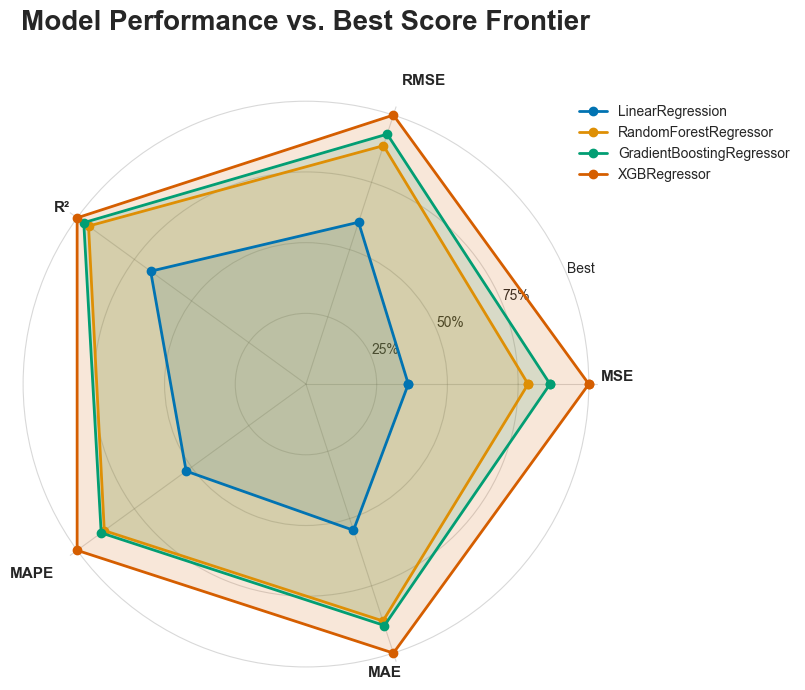

In [ ]:
# Copy the test_metrics dataframe to avoid modifying the original
df_test = test_metrics.copy()

# Set the model column as the index for easier manipulation in plotting
df_test = df_test.set_index("model")

# Create a new dataframe to hold scaled values for radar plot
df_scaled = pd.DataFrame(index=df_test.index)

# For error metrics (lower is better), scale by dividing best score by each score
# This normalizes to a [0,1] range where 1 is the best (lowest error)
for col in [
    "Mean Absolute Error (MAE)",
    "Mean Squared Error (MSE)",
    "Root Mean Squared Error (RMSE)",
    "Mean Absolute Percentage Error (MAPE)",
]:
    best_score = df_test[col].min()
    df_scaled[col] = best_score / df_test[col]

# For R-squared (higher is better), scale by dividing score by best score
# This normalizes to a [0,1] range where 1 is the best (highest R²)
best_r2 = df_test["R-squared (R²)"].max()
df_scaled["R-squared (R²)"] = df_test["R-squared (R²)"] / best_r2

# Define short labels for metrics to fit on radar axes
metric_labels = {
    "Mean Squared Error (MSE)": "MSE",
    "Mean Absolute Error (MAE)": "MAE",
    "Mean Absolute Percentage Error (MAPE)": "MAPE",
    "R-squared (R²)": "R²",
    "Root Mean Squared Error (RMSE)": "RMSE",
}

# Reorder columns for a logical radar plot layout (e.g., starting with MSE)
plot_order = [
    "Mean Squared Error (MSE)",
    "Root Mean Squared Error (RMSE)",
    "R-squared (R²)",
    "Mean Absolute Percentage Error (MAPE)",
    "Mean Absolute Error (MAE)",
]
df_plot = df_scaled[plot_order]

# Extract metric labels in the plot order
metrics = [metric_labels[col] for col in df_plot.columns]

# Calculate angles for each metric on the radar chart (evenly spaced)
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles_closed = angles + angles[:1]  # Close the polygon by repeating the first angle

# Set up the radar plot with polar coordinates
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(polar=True))

colors = sns.color_palette("colorblind", n_colors=len(df_plot))

# Plot each model's performance as a filled polygon
for i, (model, row) in enumerate(df_plot.iterrows()):
    values = row.tolist()
    values += values[:1]  # Close the shape
    ax.plot(
        angles_closed,
        values,
        color=colors[i],
        linewidth=2,
        linestyle="solid",
        label=model,
        marker="o",
    )
    ax.fill(
        angles_closed, values, color=colors[i], alpha=0.15
    )  # Fill with transparency

ax.set_rgrids([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["25%", "50%", "75%", "Best"])  # Label grid as performance levels

# Remove polar spines for cleaner look
ax.spines["polar"].set_visible(False)

ax.set_xticks(angles)
ax.set_xticklabels([])  # Hide default labels to place custom ones

# Position metric labels around the circle with appropriate alignment
for angle, label in zip(angles, metrics):
    rotation_degrees = np.rad2deg(angle)
    if 0 < rotation_degrees < 180:
        ha = "left"
    elif 180 < rotation_degrees < 360:
        ha = "right"
    else:
        ha = "center"
    if 90 < rotation_degrees < 280:
        va = "top"
    else:
        va = "bottom"
    ax.text(angle, 1.1, label, ha=ha, va=va, fontsize=11, fontweight="bold")

ax.set_title(
    "Model Performance vs. Best Score Frontier", fontsize=20, fontweight="bold", pad=45
)

# Add legend outside the plot
ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.0), fontsize=10)

# Enable grid for better readability
ax.grid(True, alpha=0.3, linewidth=0.8, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()